# Getting started with TinyTimeMixer (TTM) with Exogenous Infusion 

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks with exogenous infusion. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Fine-tune*: The pre-trained TTM will be quickly fine-tuned onthe `train` split of the target data, and subsequently, evaluated on the `test` part of the target data. During finetuing, we used the future values mentioned in `control_columns` as exogenous features for modelling. Search for `# exog:` keyword for important parameters to edit for exogenous infusion.

Note: Alternatively, this notebook can be modified to try the TTM-1024-96 model.

Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1).

## Installation

In [1]:
# Install the tsfm library
# ! pip install "tsfm_public[notebooks] @ git+ssh://git@github.com/ibm-granite/granite-tsfm.git"

## Imports

In [1]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesPreprocessor,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

/dccstor/tsfm-irl/conda_envs/envs/tsfmhf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-29 11:48:35.506773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Generate date range for one year
start_date = "2024-01-01"
end_date = "2024-12-31"
dates = pd.date_range(start=start_date, end=end_date, freq="D")

# Number of products
num_products = 10
product_ids = range(1, num_products + 1)

# Create dataset
data = []
for date in dates:
    for product_id in product_ids:
        # Identify weekends (Saturday=5, Sunday=6)
        is_weekend = 1 if date.weekday() >= 5 else 0  

        # Set base sales using seasonal patterns (sinusoidal trend + randomness)
        seasonal_factor = 10 + 5 * np.sin(2 * np.pi * date.dayofyear / 365)
        weekly_factor = 3 if is_weekend else 1  # Higher sales on weekends
        base_sales = max(5, np.random.poisson(15 + seasonal_factor * weekly_factor))

        # Apply discounts on random days (spikes)
        discount = np.random.choice([0, 1], p=[0.85, 0.15])  # 15% of days have discounts
        if discount:
            base_sales = int(base_sales * np.random.uniform(1.5, 2.5))  # Sales boost due to discount

        # Append to data list
        data.append([date, product_id, base_sales, discount, is_weekend])

# Create DataFrame
df = pd.DataFrame(data, columns=["date", "product_id", "sales", "discount", "day_type"])

# Save as CSV
df.to_csv("retail_sales_data.csv", index=False)

# Display sample
print(df.head(10))


        date  product_id  sales  discount  day_type
0 2024-01-01           1     23         0         0
1 2024-01-01           2     26         0         0
2 2024-01-01           3     27         0         0
3 2024-01-01           4     20         0         0
4 2024-01-01           5     22         0         0
5 2024-01-01           6     22         0         0
6 2024-01-01           7     22         0         0
7 2024-01-01           8     30         0         0
8 2024-01-01           9     26         0         0
9 2024-01-01          10     46         1         0


## Important arguments

In [3]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here ettm2) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "sales retail"
DATA_ROOT_PATH = "retail_sales_data.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model

# Forecasting parameters
context_length = 90
forecast_length = 30

## Data processing pipeline

In [4]:
# Load the data file and see the columns

timestamp_column = "date"
# timestamp_column = "timestamp"
id_columns = ["product_id"]


data = pd.read_csv(
    DATA_ROOT_PATH,
    parse_dates=[timestamp_column],
)


data[timestamp_column] = pd.to_datetime(data[timestamp_column])

print(data)
# data = pd.read_csv(
#     "/dccstor/tsfm23/datasets/exogs_expts/bike_sharing_dataset/processed_data/bike_sharing_hourly_processed.csv",
#     # parse_dates=[timestamp_column],
# )

# print(data)

# exog: Mention Exog channels in control_columns and target in target_columns

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": ["sales"],
    "control_columns": [
        "discount",
        "day_type",
    ],
}

split_params = {"train": [0, 0.5], "valid": [0.5, 0.75], "test": [0.75, 1.0]}

           date  product_id  sales  discount  day_type
0    2024-01-01           1     23         0         0
1    2024-01-01           2     26         0         0
2    2024-01-01           3     27         0         0
3    2024-01-01           4     20         0         0
4    2024-01-01           5     22         0         0
...         ...         ...    ...       ...       ...
3655 2024-12-31           6     47         1         0
3656 2024-12-31           7     19         0         0
3657 2024-12-31           8     24         0         0
3658 2024-12-31           9     20         0         0
3659 2024-12-31          10     66         1         0

[3660 rows x 5 columns]


In [5]:
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp,
    data,
    split_params,
    use_frequency_token = True
)

In [6]:
train_dataset[3]

{'past_values': tensor([[-0.7698, -0.4339, -0.6300],
         [-0.7258, -0.4339, -0.6300],
         [ 1.0323,  2.3044,  1.5872],
         [ 0.5928, -0.4339,  1.5872],
         [-0.6379, -0.4339, -0.6300],
         [-0.4621, -0.4339, -0.6300],
         [-0.7258, -0.4339, -0.6300],
         [-0.5940, -0.4339, -0.6300],
         [-0.5061, -0.4339, -0.6300],
         [ 0.4169, -0.4339,  1.5872],
         [ 1.9992,  2.3044,  1.5872],
         [ 1.0762,  2.3044, -0.6300],
         [ 0.9444,  2.3044, -0.6300],
         [-1.0774, -0.4339, -0.6300],
         [-0.5061, -0.4339, -0.6300],
         [-0.6379, -0.4339, -0.6300],
         [ 0.6367, -0.4339,  1.5872],
         [ 0.9883, -0.4339,  1.5872],
         [-0.4181, -0.4339, -0.6300],
         [-0.5940, -0.4339, -0.6300],
         [-0.8577, -0.4339, -0.6300],
         [ 0.4169,  2.3044, -0.6300],
         [-0.8577, -0.4339, -0.6300],
         [ 0.2411, -0.4339,  1.5872],
         [ 1.0762, -0.4339,  1.5872],
         [-0.3742, -0.4339, -0.6300

## Zero-shot evaluation method

In [7]:
TTM_MODEL_PATH = "/dccstor/tsfm23/vj_share/models/short_model_release/vj_ttm_90_30_freq_d_big_v2-ver1-r-c64731db/models/ttm_model"

zeroshot_model = get_model(
    TTM_MODEL_PATH,
    context_length=context_length,
    prediction_length=forecast_length,
    prediction_channel_indices=tsp.prediction_channel_indices,
    num_input_channels=tsp.num_input_channels,
)

zeroshot_model

INFO:p-977832:t-23282957198080:get_model.py:get_model:Loading model from: /dccstor/tsfm23/vj_share/models/short_model_release/vj_ttm_90_30_freq_d_big_v2-ver1-r-c64731db/models/ttm_model
INFO:p-977832:t-23282957198080:get_model.py:get_model:Model loaded successfully!
INFO:p-977832:t-23282957198080:get_model.py:get_model:[TTM] context_len = 90, forecast_len = 30


TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=9, out_features=90, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0-19): 20 x TinyTimeMixerLayer(
            (patch_mixer): PatchMixerBlock(
              (norm): TinyTimeMixerNormLayer(
                (norm): LayerNorm((90,), eps=1e-05, elementwise_affine=True)
              )
              (mlp): TinyTimeMixerMLP(
                (fc1): Linear(in_features=11, out_features=22, bias=True)
                (dropout1): Dropout(p=0.3, inplace=False)
                (fc2): Linear(in_features=22, out_features=11, bias=True)
                (dropout2): Dropout(p=0.3, inplace=False)
              )
              (gating_block): TinyTimeMixerGatedAttention(
                (attn_layer): Linear(in_features=11, out_features=11, bias=True)
                (attn_softmax): Softmax(dim=-1)
              )
        

In [8]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    ),
)

INFO:p-977832:t-23282957198080:base.py:add_job:Adding job tentatively -- it will be properly scheduled when the scheduler starts


In [9]:
zeroshot_trainer.evaluate(test_dataset)

{'eval_loss': 0.7184484004974365,
 'eval_runtime': 0.659,
 'eval_samples_per_second': 956.04,
 'eval_steps_per_second': 15.175}

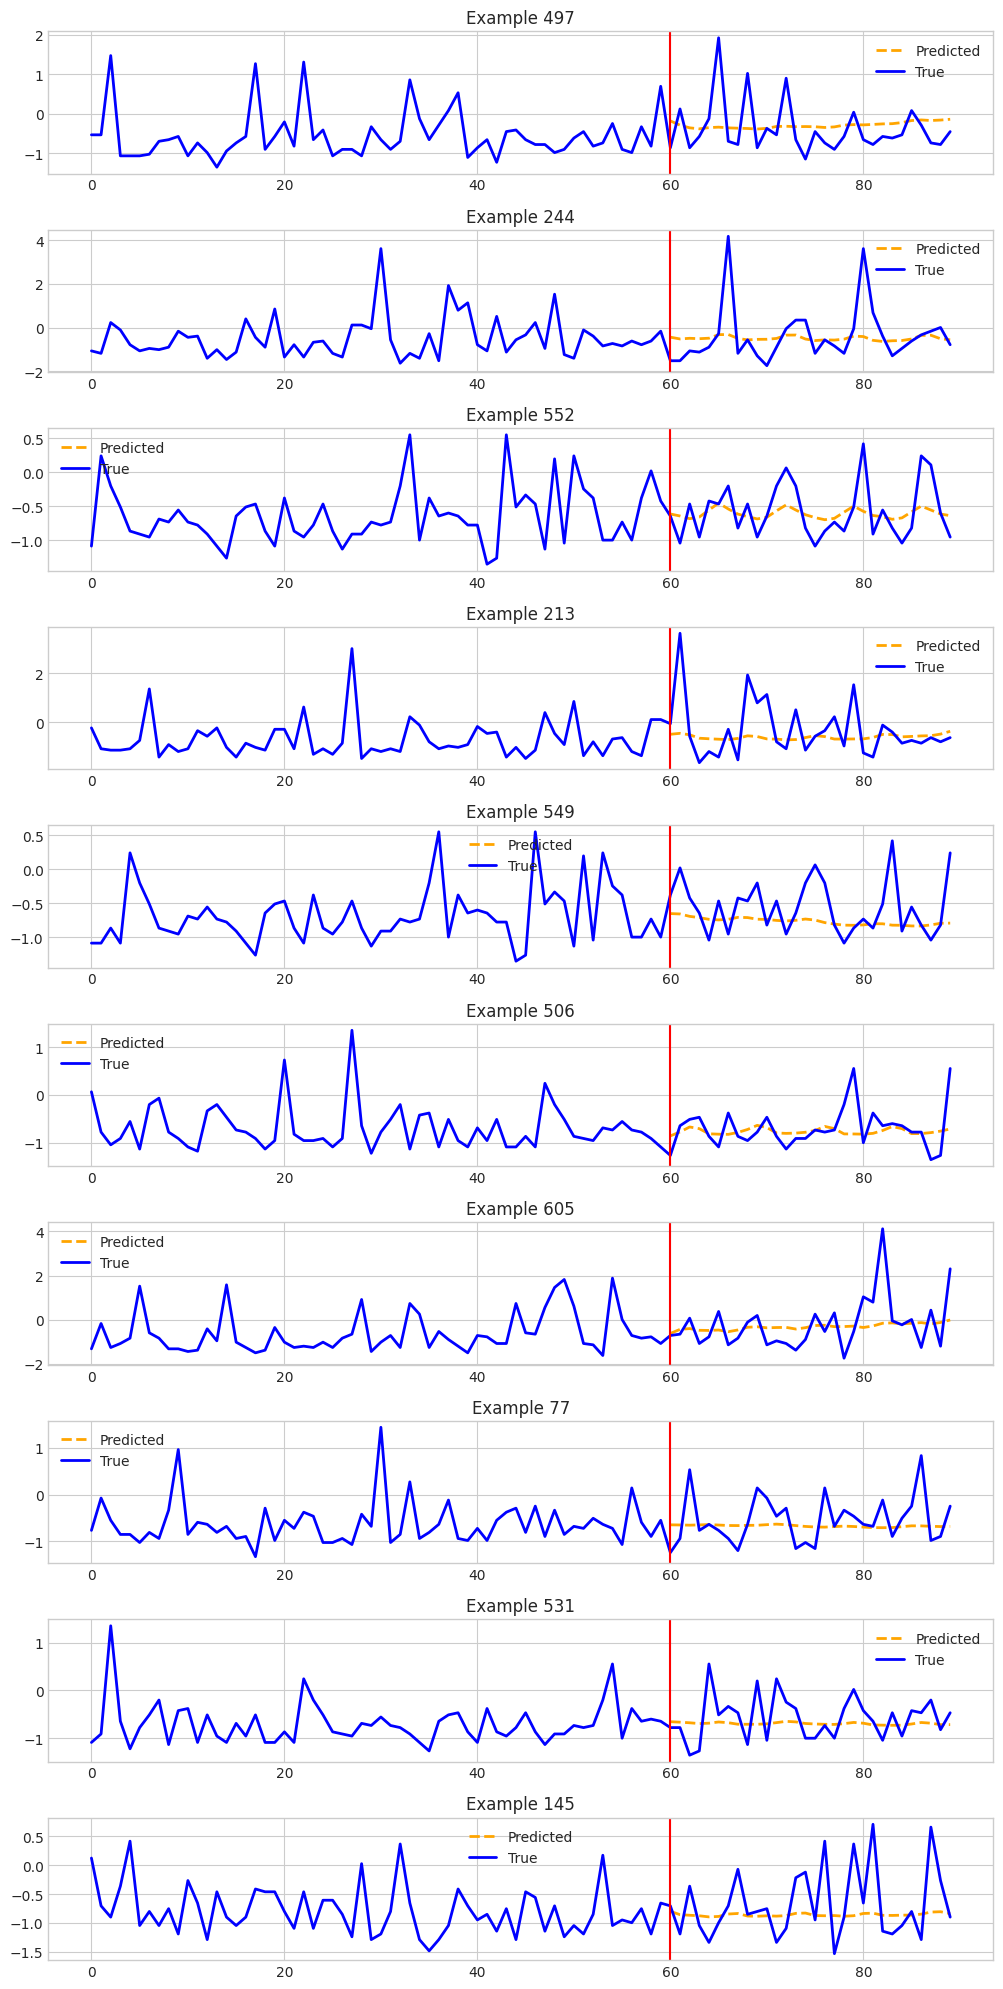

In [10]:
# plot
plot_predictions(
    model=zeroshot_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, "bike_sharing"),
    plot_prefix="test_zeroshot",
    channel=0,
)

 ## Few-shot finetune and evaluation method

### Load model
Optionally, we can change some parameters of the model, e.g., dropout of the head.

In [11]:
finetune_forecast_model = get_model(
    TTM_MODEL_PATH,
    context_length=context_length,
    prediction_length=forecast_length,
    num_input_channels=tsp.num_input_channels,
    decoder_mode="mix_channel",  # exog:  set to mix_channel for mixing channels in history
    prediction_channel_indices=tsp.prediction_channel_indices,
    exogenous_channel_indices=tsp.exogenous_channel_indices,
    fcm_context_length=1,  # exog: indicates lag length to use in the exog fusion. for Ex. if today sales can get affected by discount on +/- 2 days, mention 2
    fcm_use_mixer=True,  # exog: Try true (1st option) or false
    fcm_mix_layers=2,  # exog: Number of layers for exog mixing
    enable_forecast_channel_mixing=True,  # exog: set true for exog mixing
    fcm_prepend_past=True,  # exog: set true to include lag from history during exog infusion.
)
finetune_forecast_model

INFO:p-977832:t-23282957198080:get_model.py:get_model:Loading model from: /dccstor/tsfm23/vj_share/models/short_model_release/vj_ttm_90_30_freq_d_big_v2-ver1-r-c64731db/models/ttm_model
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at /dccstor/tsfm23/vj_share/models/short_model_release/vj_ttm_90_30_freq_d_big_v2-ver1-r-c64731db/models/ttm_model and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=9, out_features=90, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0-19): 20 x TinyTimeMixerLayer(
            (patch_mixer): PatchMixerBlock(
              (norm): TinyTimeMixerNormLayer(
                (norm): LayerNorm((90,), eps=1e-05, elementwise_affine=True)
              )
              (mlp): TinyTimeMixerMLP(
                (fc1): Linear(in_features=11, out_features=22, bias=True)
                (dropout1): Dropout(p=0.3, inplace=False)
                (fc2): Linear(in_features=22, out_features=11, bias=True)
                (dropout2): Dropout(p=0.3, inplace=False)
              )
              (gating_block): TinyTimeMixerGatedAttention(
                (attn_layer): Linear(in_features=11, out_features=11, bias=True)
                (attn_softmax): Softmax(dim=-1)
              )
        

### Frezze the TTM backbone

In [12]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 861947
Number of params after freezing the backbone 18587


### Finetune model with decoder mixing and exog fusion

In [15]:
# Important parameters


# learning_rate = 0.000298364724028334
num_epochs = 50  # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

learning_rate, finetune_forecast_model = optimal_lr_finder(
    finetune_forecast_model,
    train_dataset,
    batch_size=batch_size,
    enable_prefix_tuning=True,
)
print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

INFO:p-977832:t-23282957198080:lr_finder.py:optimal_lr_finder:LR Finder: Running learning rate (LR) finder algorithm. If the suggested LR is very low, we suggest setting the LR manually.
INFO:p-977832:t-23282957198080:lr_finder.py:optimal_lr_finder:LR Finder: Using GPU:0.
INFO:p-977832:t-23282957198080:lr_finder.py:optimal_lr_finder:LR Finder: Suggested learning rate = 0.0009111627561154895


OPTIMAL SUGGESTED LEARNING RATE = 0.0009111627561154895


In [16]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

INFO:p-977832:t-23282957198080:base.py:add_job:Adding job tentatively -- it will be properly scheduled when the scheduler starts


Using learning rate = 0.0009111627561154895


INFO:p-977832:t-23282957198080:base.py:_real_add_job:Added job "EmissionsTracker._measure_power" to job store "default"
INFO:p-977832:t-23282957198080:base.py:start:Scheduler started


Epoch,Training Loss,Validation Loss
1,2.917300,1.276503
2,2.735700,1.117513
3,2.392300,0.906477
4,2.071900,0.675945
5,1.643400,0.499465
6,1.389500,0.435449
7,1.247400,0.431727
8,1.206300,0.386672
9,1.053100,0.395744
10,0.953800,0.414215


INFO:p-977832:t-23269809739520:base.py:run_job:Running job "EmissionsTracker._measure_power (trigger: interval[0:00:15], next run at: 2025-01-29 11:49:48 EST)" (scheduled at 2025-01-29 11:49:48.632646-05:00)
INFO:p-977832:t-23269809739520:base.py:run_job:Job "EmissionsTracker._measure_power (trigger: interval[0:00:15], next run at: 2025-01-29 11:50:03 EST)" executed successfully
INFO:p-977832:t-23269809739520:base.py:run_job:Running job "EmissionsTracker._measure_power (trigger: interval[0:00:15], next run at: 2025-01-29 11:50:18 EST)" (scheduled at 2025-01-29 11:50:03.632646-05:00)
INFO:p-977832:t-23269809739520:base.py:run_job:Job "EmissionsTracker._measure_power (trigger: interval[0:00:15], next run at: 2025-01-29 11:50:18 EST)" executed successfully
INFO:p-977832:t-23282957198080:base.py:shutdown:Scheduler has been shut down
ERROR:p-977832:t-23282957198080:emissions.py:get_private_infra_emissions:Region:  not found for Country with ISO CODE : USA


[TrackingCallback] Mean Epoch Time = 0.7475465491965965 seconds, Total Train Time = 38.505805015563965


TrainOutput(global_step=270, training_loss=0.9275869245882388, metrics={'train_runtime': 36.3692, 'train_samples_per_second': 879.865, 'train_steps_per_second': 13.748, 'total_flos': 24126480115200.0, 'train_loss': 0.9275869245882388, 'epoch': 27.0})

In [17]:
finetune_forecast_trainer.evaluate(test_dataset)

{'eval_loss': 0.2733955383300781,
 'eval_runtime': 0.5242,
 'eval_samples_per_second': 1201.884,
 'eval_steps_per_second': 19.078,
 'epoch': 27.0}

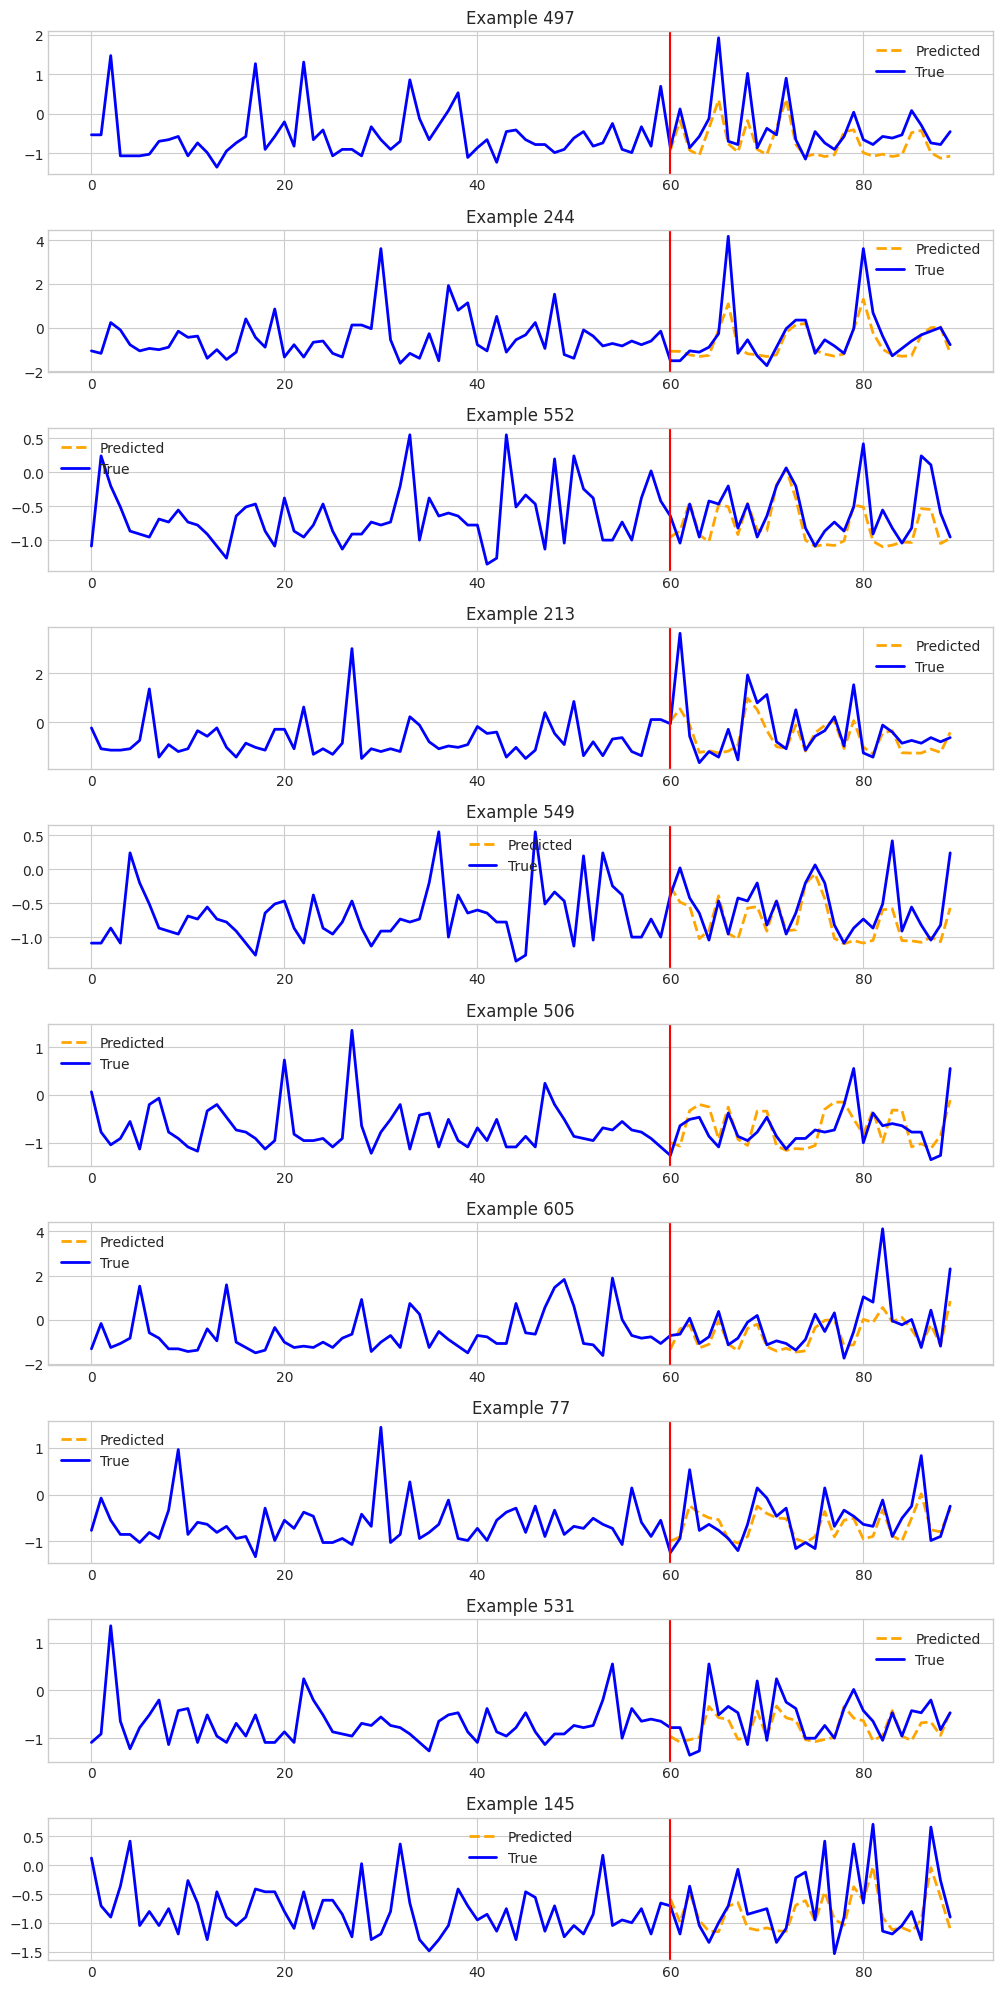

In [18]:
plot_predictions(
    model=finetune_forecast_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, "bike_sharing"),
    plot_prefix="test_finetune",
    channel=0,
)